In [3]:
import os

import IPython.display as ipd
import keras
import librosa
import matplotlib.pyplot as plt 
import numpy as np
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D, Reshape

In [4]:
# Using the standardized 2-second truncated audio files

train_real_directory = "/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/real"
train_fake_directory = "/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/fake"

validation_real_directory = "/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/validation/real"
validation_fake_directory = "/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/validation/fake"

test_real_directory = "/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/real"
test_fake_directory = "/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/fake"# Using the standardized 2-second truncated audio files


In [6]:
# Get waveform (.wav) audio files

train_real_audio = [os.path.join(train_real_directory, file) for file in os.listdir(train_real_directory) if file.endswith('.wav')]
train_fake_audio = [os.path.join(train_fake_directory, file) for file in os.listdir(train_fake_directory) if file.endswith('.wav')]

validation_real_audio = [os.path.join(validation_real_directory, file) for file in os.listdir(validation_real_directory) if file.endswith('.wav')]
validation_fake_audio = [os.path.join(validation_fake_directory, file) for file in os.listdir(validation_fake_directory) if file.endswith('.wav')]

test_real_audio = [os.path.join(test_real_directory, file) for file in os.listdir(test_real_directory) if file.endswith('.wav')]
test_fake_audio = [os.path.join(test_fake_directory, file) for file in os.listdir(test_fake_directory) if file.endswith('.wav')]

In [7]:
# Taking a random audio file
random_audio_file = train_real_audio[random.randint(0, 6977)]
ipd.Audio(random_audio_file)

In [8]:
random_faudio_file = train_fake_audio[random.randint(0,1628)]
ipd.Audio(random_faudio_file)

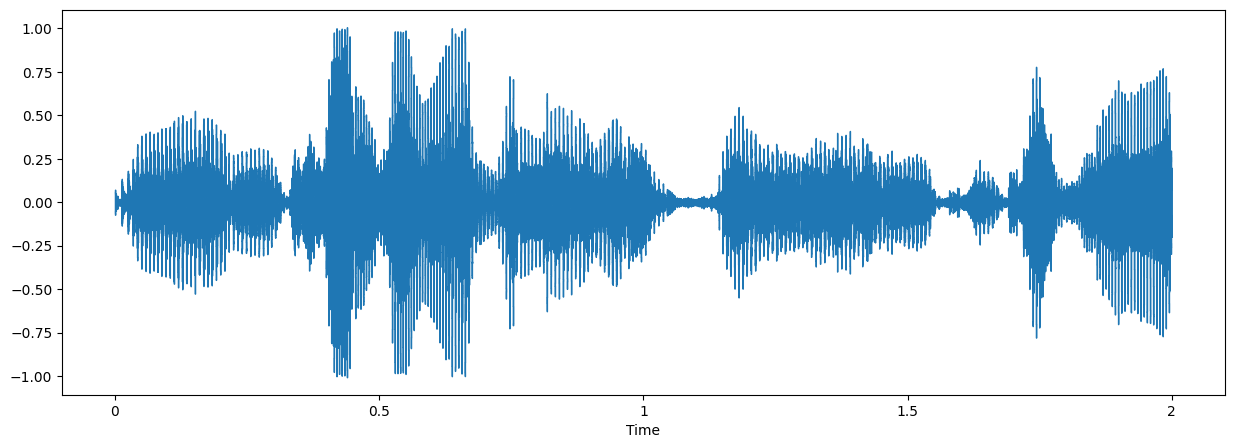

In [9]:
# Visualize waveform of sample audio above
# sr (sample rate) refers to the frequency of "snapshots" of the audio used for digital representation
audio_data, sample_rate = librosa.load(random_audio_file)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(audio_data, sr=sample_rate)

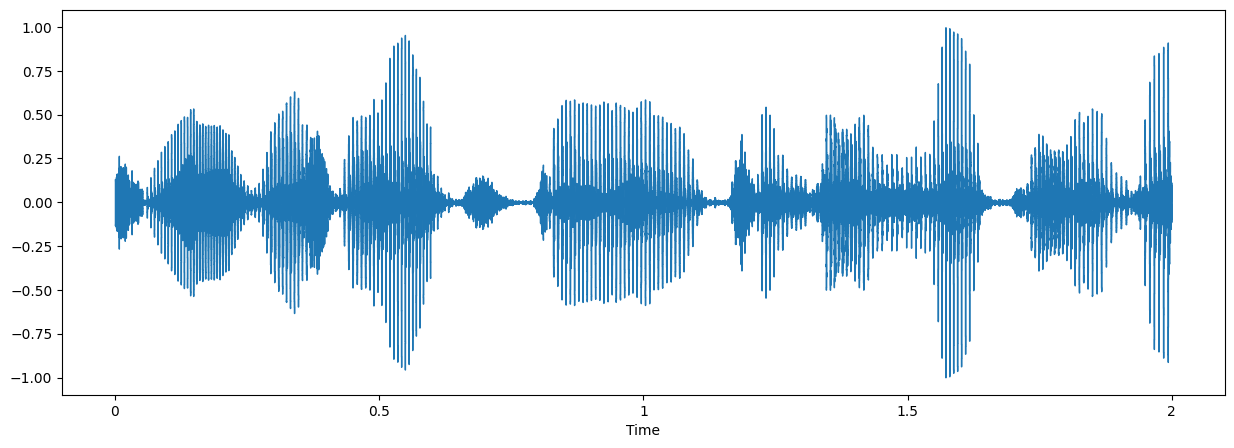

In [10]:
audio_data, sample_rate = librosa.load(random_faudio_file )
plt.figure(figsize=(15, 5))
librosa.display.waveshow(audio_data, sr=sample_rate)

In [12]:
def create_mel_spectrogram(file_path):
    audio_data, sample_rate = librosa.load(file_path)  
    # Convert audio to mel-based spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    # Convert from amplitude squared to decibel units
    mel_decibel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  
    return mel_decibel_spectrogram

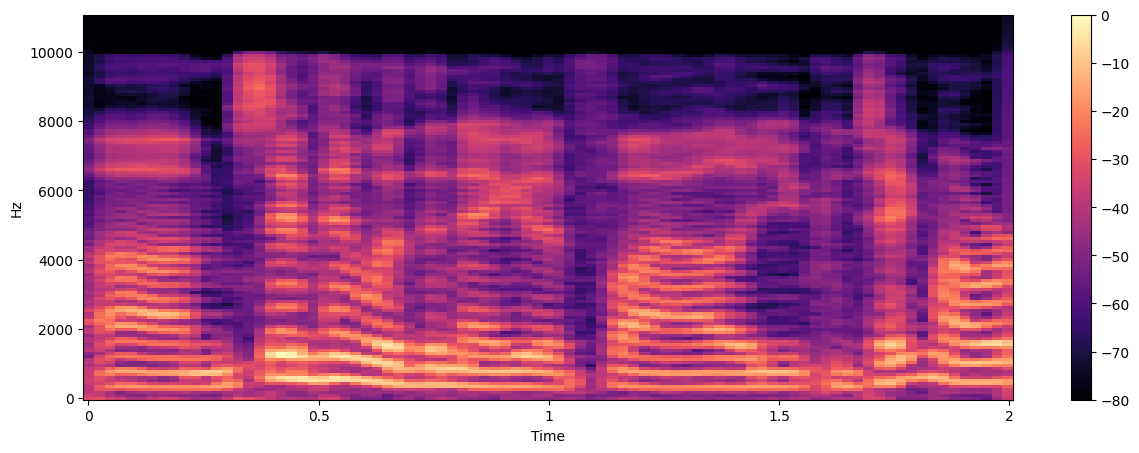

In [13]:
sample_spectrogram = create_mel_spectrogram(random_audio_file)
plt.figure(figsize=(15, 5))
librosa.display.specshow(sample_spectrogram, x_axis='time', y_axis='hz')
plt.colorbar()

In [14]:
def get_features_and_labels(real_audio_files, fake_audio_files):
    spec_arr = []
    labels = []
    
    for file in real_audio_files:
        spectrogram = create_mel_spectrogram(file)
        spec_arr.append(spectrogram)
        labels.append(0)
    for file in fake_audio_files:
        spectrogram = create_mel_spectrogram(file)
        spec_arr.append(spectrogram)
        labels.append(1)
    
    return np.array(spec_arr), np.array(labels)

In [15]:
train_features, train_labels = get_features_and_labels(train_real_audio, train_fake_audio)
validation_features, validation_labels = get_features_and_labels(validation_real_audio, validation_fake_audio)
test_features, test_labels = get_features_and_labels(test_real_audio, test_fake_audio)

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomHeight(0.2),           # Random height shift
    layers.RandomWidth(0.2),            # Random width shift
    layers.RandomRotation(0.1),         # Random rotation
    layers.RandomZoom(0.2),             # Random zoom
    layers.RandomFlip("horizontal"),    # Random horizontal flip
])

In [17]:

# Define augmentation for training dataset
def augment(image, label):
    # Ensure image has a channel dimension
    image = tf.expand_dims(image, axis=-1)
    # Apply data augmentation
    image = data_augmentation(image)
    return image, label


In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.map(augment).batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

Train features shape: (13956, 128, 87)
Test features shape: (1088, 128, 87)


In [21]:
# Define the Custom Convolutional Neural Network (cCNN)
def build_custom_cnn(input_shape):
    model = models.Sequential()
    
    # First Convolutional Layer: 64 filters, kernel size (3x3), ReLU, MaxPooling
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    
    # Second Convolutional Layer: 128 filters, kernel size (5x5), ReLU, MaxPooling
    model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    
    # Third Convolutional Layer: 128 filters, kernel size (5x5), ReLU, MaxPooling
    model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    
    # Fourth Convolutional Layer: 256 filters, kernel size (5x5), ReLU, MaxPooling
    model.add(layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    
    # Flatten Layer: Convert 3D volume to 1D vector
    model.add(layers.Flatten())
    
    # First Fully Connected Layer: 512 neurons, ReLU, Dropout (25%)
    model.add(layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.30))
    
    # Second Fully Connected Layer: 1024 neurons, ReLU
    model.add(layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    
    # Output Layer: Binary classification (real/fake), Sigmoid activation
    model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification
    
    return model

# Define input shape for mel spectrograms
input_shape = (128, 87, 1)  # Add a channel dimension for the grayscale spectrograms

model = build_custom_cnn(input_shape)
# Summary of the model
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 87, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 44, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 22, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 11, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,253,057 (31.48 MB)

 Trainable params: 8,253,057 (31.48 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Build and compile the model
learning_rate =0.001# Example: Lower learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [23]:
Cccn_history = model.fit(train_features,
                                      train_labels,
                                      validation_data = [validation_features, validation_labels],
                                      batch_size = 32,
                                      epochs = 20,
                                      verbose=2)

Epoch 1/20


I0000 00:00:1734119585.177468     137 service.cc:145] XLA service 0x7d2a74005fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734119585.177522     137 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734119590.842257     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


437/437 - 19s - 44ms/step - accuracy: 0.7527 - loss: 3.4387 - val_accuracy: 0.9381 - val_loss: 0.9863
Epoch 2/20
437/437 - 7s - 17ms/step - accuracy: 0.9534 - loss: 0.5943 - val_accuracy: 0.9671 - val_loss: 0.3296
Epoch 3/20
437/437 - 7s - 17ms/step - accuracy: 0.9717 - loss: 0.2335 - val_accuracy: 0.9919 - val_loss: 0.1183
Epoch 4/20
437/437 - 7s - 17ms/step - accuracy: 0.9848 - loss: 0.1052 - val_accuracy: 0.9919 - val_loss: 0.0652
Epoch 5/20
437/437 - 7s - 17ms/step - accuracy: 0.9867 - loss: 0.0677 - val_accuracy: 0.9830 - val_loss: 0.0814
Epoch 6/20
437/437 - 8s - 17ms/step - accuracy: 0.9851 - loss: 0.0698 - val_accuracy: 0.9862 - val_loss: 0.0578
Epoch 7/20
437/437 - 7s - 17ms/step - accuracy: 0.9877 - loss: 0.0590 - val_accuracy: 0.9858 - val_loss: 0.1078
Epoch 8/20
437/437 - 7s - 17ms/step - accuracy: 0.9889 - loss: 0.0622 - val_accuracy: 0.9901 - val_loss: 0.0487
Epoch 9/20
437/437 - 7s - 17ms/step - accuracy: 0.9917 - loss: 0.0447 - val_accuracy: 0.9887 - val_loss: 0.0454
Ep

In [25]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9389 - loss: 0.1992


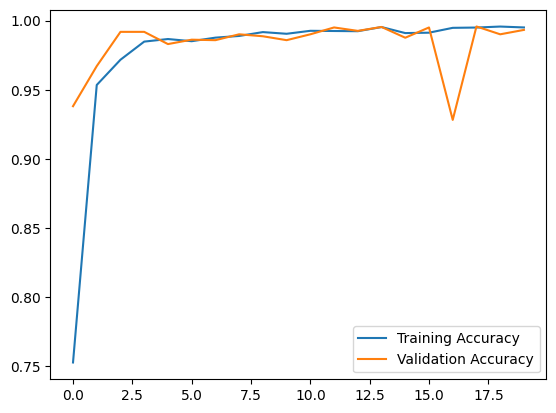

In [26]:
import matplotlib.pyplot as plt

''' plotting the progress of training and validation accuracy '''

plt.plot(Cccn_history.history['accuracy'], label='Training Accuracy')
plt.plot(Cccn_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [30]:
from tensorflow.keras.models import save_model
model.save('model.h5')